# TP2: Équation de la chaleur

Le but de ce TP est de calculer numériquement de deux façons différentes la solution du problème de diffusion avec conditions au bord de type Neumann,
$$
\begin{cases}
    \partial_t u(x,t) + \partial_{xx}^2 u = 0, & (x,t) \in (0,1) \times (0, \infty), \\
    u(x, 0) = u_0(x), \\
    \partial_x u(0, t) = \partial_x u(1,t) = 0 .
\end{cases}
$$
Ce problème d'évolution peut modéliser, par exemple, la densité de probabilité d'une particule en mouvement brownien dans une boîte.

Pour les applications, on choisira la condition initiale
$$
u_0(x) = \begin{cases}
    1 & \text{si~~} 1/4 \leq x \leq 1/2, \\
    0 & \text{sinon}.
\end{cases}
$$

### 1. Différences finies et Euler explicite

On cherche d'abord à calculer une solution numérique à ce problème par différences finies, en ne faisant que des calculs explicites avec la méthode d'Euler.

#### 1.1/ Utilitaires de discrétisation

**1.1.a)** Écrire une fonction `neumann_discretisation` qui prend en entrée la taille du système `N` et qui renvoie le vecteur de points de collocation $(x_1, ..., x_N)^{\sf T}$ associé. Valider cette fonction en affichant le résultat de `neumann_discretisation(2)` grâce à la fonction `display`.

**1.1.b)** Écrire une fonction `poisson_matrix` qui prend en entrée la taille du système et qui construit la matrice de Poisson associée. Valider cette fonction en affichant le résultat de `poisson_matrix(5)`. Pour éviter d'allouer de la mémoire inutile, on utilisera la structure `Tridiagonal` du module `LinearAlgebra`.

**1.1.c)** Surcharger la fonction `mul!` pour les matrices `Tridiagonal`.

In [1]:
using LinearAlgebra: Tridiagonal

function neumann_discretisation!(N) #LT: `!` sert à indiquer que la fonction modifie ses arguments. Ce n'est pas le cas ici, donc on peut l'enlever.
  x = Vector{Float64}(undef, N)
  dx = 1.0/N
  for i in 1:N
    x[i] = (i - 0.5 ) * dx #LT: oui
  end
  return x
end

x = neumann_discretisation!(2)

2-element Vector{Float64}:
 0.25
 0.75

In [2]:
function poisson_matrix!(N)
  dl = fill(-1.0, N-1) #LT: attention au type ! On voudrait des flottants, pas des entiers
  d = fill(2.0, N)
  du = fill(-1.0, N-1)

  d[1] = 1
  d[N] = 1

  return Tridiagonal(dl, d, du)
end
 
P = poisson_matrix!(5)

5×5 Tridiagonal{Float64, Vector{Float64}}:
  1.0  -1.0    ⋅     ⋅     ⋅ 
 -1.0   2.0  -1.0    ⋅     ⋅ 
   ⋅   -1.0   2.0  -1.0    ⋅ 
   ⋅     ⋅   -1.0   2.0  -1.0
   ⋅     ⋅     ⋅   -1.0   1.0

In [3]:
function mul!(y::Vector, A::Tridiagonal, x::Vector)
  N = length(x)

  y[1] = A.d[1] * x[1] + A.du[1] * x[2] 

  for i in 2:N-1
    y[i] = A.dl[i-1] * x[i-1] + A.d[i] * x[i] + A.du[i] * x[i+1]
  end

  y[N] = A.dl[N-1] * x[N-1] + A.d[N] * x[N]

  return y
end

b = Float64[1.0, 2.5, 3.7, 4.2, 5.5]
y = Float64[0, 0, 0, 0, 0]
y = mul!(y, P, b)
display(y)
P*b
#LT: bien pour la vérification

5-element Vector{Float64}:
 -1.5
  0.2999999999999998
  0.7000000000000002
 -0.7999999999999998
  1.2999999999999998

5-element Vector{Float64}:
 -1.5
  0.2999999999999998
  0.7000000000000002
 -0.7999999999999998
  1.2999999999999998

#### 1.2/ Méthode d'Euler explicite

Écrire une fonction `simulate_explicit_euler` qui prend en entrée une fonction `u0` de conditions initiales, `Nx` le nombre de points en espace, `T` le temps final et `Nt` le nombre de pas de temps, et qui renvoie le maillage $(x_i)$ ainsi que la solution numérique $U^{N_t}_i \approx u(x_i, T)$ calculée par méthode d'Euler explicite. On pourra utiliser la structure `Diagonal` ou la variable "magique" `I` de `LinearAlgebra`.

*Pour aller plus loin :* Rajouter un argument optionnel `save_at` dans la fonction qui sauvegarde la solution aux temps indiqués par cet argument.

In [4]:
function u0(x)
  if 1/4 <= x <= 1/2
    return 1.
  end

  return 0.
end

u0 (generic function with 1 method)

In [5]:
using LinearAlgebra: Diagonal, I

function simulate_explicit_euler!(u0::Function, Nx::Int64, T::Float64, Nt::Int64)
  x = neumann_discretisation!(Nx)
  dx = 1.0/Nx
  dt = T/Nt
  U = Vector{Float64}(undef, Nx)
  y = Vector{Float64}(undef, Nx)
  A = poisson_matrix!(Nx)

  "conditions initiales"
  for (i, xi) in enumerate(x)
    U[i] = u0(xi) #LT: plus simple avec `U = u0.(x)`
  end
  
  B = (I - dt / dx^2 * A) #LT: super de stocker cette matrice hors de la boucle

  # for t in 2:Nt
  for t in 1:Nt
    mul!(y, B, U) #LT: bonne utilisation de `mul!` pour éviter les allocations inutiles
    # U = copy(y) #LT: moins efficace que U .= y
    U .= y
    # U = B * U
    #LT: ^ oui !
  end
  
  return x, U
end

simulate_explicit_euler! (generic function with 1 method)

In [6]:
"test"
Nt = 10
Nx = 10
T = 10^-2

x, U = simulate_explicit_euler!(u0, Nx, T, Nt)

display(U)

10-element Vector{Float64}:
 0.17059997460000006
 0.3534235991000002
 0.6111161067000004
 0.7296121731000004
 0.6101590296000002
 0.34643732620000023
 0.1342774572000001
 0.036322830800000025
 0.006993083100000003
 0.0010584196000000003

#### 1.3/ Solution et CFL

Avec $N_x = 1000$, calculer la solution après 100 pas de temps avec une condition CFL $\Delta t / \Delta x^2 = 0.51$ et la tracer. Quelle différence observe-t-on par rapport aux solutions au même temps final avec des conditions CFL $\Delta t / \Delta x^2 \in \{0.1, 0.5\}$ ?

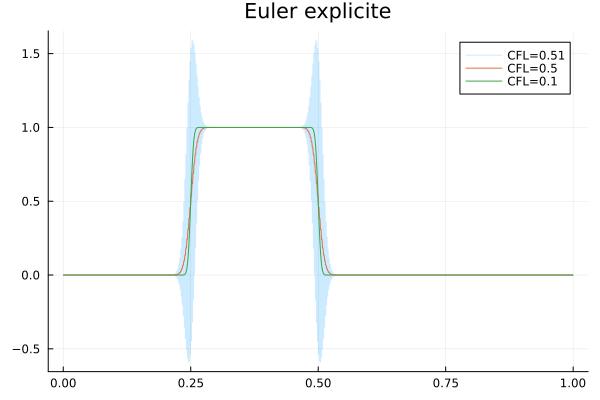

In [7]:
using Plots, LaTeXStrings

Nx = 1000
Nt = 100
CFL = [0.51, 0.5, 0.1]
T1 = CFL[1] * Nt / Nx^2
T2 = CFL[2] * Nt / Nx^2
T3 = CFL[3] * Nt / Nx^2
#LT: /!\ avec ces définitions, on ne calcule pas la solution au même temps selon la CFL

x, U1 = simulate_explicit_euler!(u0, Nx, T1, Nt)
x, U2 = simulate_explicit_euler!(u0, Nx, T2, Nt)
x, U3 = simulate_explicit_euler!(u0, Nx, T3, Nt)

p = plot()
plot!(p, x, U1, label="CFL=0.51", alpha=0.2)
plot!(p, x, U2, label="CFL=0.5")
plot!(p, x, U3, label="CFL=0.1")

title!("Euler explicite")

Seul la condition CFL=0.51 rend le schema instable ce qui est cohérent avec ce qu'on a vu en cours :  
condition de stabilité dite CFL : $\frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}$   
Plus la condition CFL diminue, plus la solution est précise (et le schema stable).

**LT:** Bien pour la première partie, pour la condition de stabilité ! Et effectivement le schéma est censé être plus précis avec une CFL plus faible, mais ce n'est pas ce qu'on observe au-dessus. La différence est invisible à l'œil nu sur cette figure.

### 2. Implémentation de méthodes implicites

Afin de s'affranchir de la contrainte de CFL, on cherche maintenant à implémenter des schémas temporels implicites.

#### 2.1/ Utilitaires pour la factorisation LU

Reprendre le TP précédent pour définir une structure `TridiagLU` avec les routines `factorize!`, `mul!` et `solve!`, ainsi que le constructeur `TridiagLU(A::AbstractMatrix)`.

Tester ce code sur la matrice $A_3 = \begin{pmatrix} 2 & -1 & 0 \\ -1 & 2 & -1 \\ 0 & -1 & 2 \end{pmatrix}$, en comparant avec une factorisation LU manuelle.

In [8]:
struct TridiagLU
  lower :: Vector{Float64}
  diag :: Vector{Float64}
  upper :: Vector{Float64}
end

"Initialisation de la mémoire pour une factorisation n×n"
TridiagLU(n::Int64) = TridiagLU(zeros(n-1), zeros(n), zeros(n-1))
Base.size(A::TridiagLU) = (length(A.diag), length(A.diag))

In [9]:
function factorize!(LU::TridiagLU, A::AbstractMatrix)
  n = size(A, 1)
  lower, diag, upper = zeros(n-1), zeros(n), zeros(n-1)
  LU.diag[1] = A[1, 1]
  for i in 2:n
    LU.lower[i-1] = A[i, i-1] / LU.diag[i-1]
    LU.upper[i-1] = A[i-1, i]
    LU.diag[i] = A[i, i] - LU.lower[i-1] * LU.upper[i-1]
  end
  return LU
 end

factorize! (generic function with 1 method)

In [10]:
function TridiagLU(A::AbstractMatrix)
  LU = TridiagLU(size(A, 1)) # on initialise la mémoire
  factorize!(LU, A) # on effectue la factorisation
 end

TridiagLU

In [11]:
function mul!(y::Vector, A::TridiagLU, x::Vector)
  N = length(x)

  y[1] = A.diag[1] * x[1] + A.upper[1] * x[2]
  
  for i in 2:N-1
    y[i] = A.diag[i] * x[i] + A.upper[i] * x[i+1]
  end
  y[N] = A.diag[N] * x[N]
  for i in 2:N-1
    y[i] = A.lower[i-1] * y[i-1] + y[i]
  end
  #LT: presque ! Il faut faire attention à l'ordre des opérations. Mais cette fonction ne sert pas, normalement, de toute façon.
  y[N] = A.lower[N-1] * y[N-1] + y[N]
  
  return y
end

mul! (generic function with 2 methods)

In [12]:
function _solve_l!(y, LU, b)
  n = length(b)

  y[1] = b[1]
  for i in 2:n
    y[i] = b[i] - LU.lower[i-1]*y[i-1]
  end

  return y
 end

 function _solve_u!(x, LU, y)
  n = length(x)

  x[n] = y[n] / LU.diag[n]
  for i in reverse(1:n-1)
    x[i] = (y[i] - LU.upper[i] * x[i+1]) / LU.diag[i]
  end 

  return x
 end

 """
solve!(x::Vector{Float64}, LU::TridiagLU, b::Vector{Float64})

Résout le système `LU*x = b` en modifiant `x` "in-place".
 """
 function solve!(x::Vector{Float64}, LU::TridiagLU, b::Vector{Float64})
  _solve_l!(x, LU, b)
  _solve_u!(x, LU, x)
  return x
 end

solve!

In [13]:
"test"
A = [2 -1 0;
    -1 2 -1;
    0 -1 2]
LU = TridiagLU(A)
display(LU)

TridiagLU([-0.5, -0.6666666666666666], [2.0, 1.5, 1.3333333333333335], [-1.0, -1.0])

In [14]:
"test"
x = [5., 3., 3.]
y = Vector{Float64}(undef, 3)
y = mul!(y, LU, x)
y1 = A * x

display(y)
display(y1) #LT: woops

3-element Vector{Float64}:
  7.0
 -2.0
  5.333333333333333

3-element Vector{Float64}:
  7.0
 -2.0
  3.0

In [15]:
"test"
b = [1., 1., 2.]

x= Vector{Float64}(undef, 3)
x = solve!(x, LU, b)
display(x) #LT: est-ce le résultat auquel on s'attendait ? Pourquoi ?

3-element Vector{Float64}:
 1.7499999999999998
 2.4999999999999996
 2.2499999999999996

#### 2.1. Implémentation du $\theta$-schéma

Écrire une fonction `simulate_theta_scheme` qui prend en entrée les mêmes arguments que la fonction `simulate_explicit_euler` mais avec en plus un argument optionnel `θ = 0.5`. Cette fonction doit renvoyer le maillage $(x_i)$ ainsi que la solution numérique $U^{N_t}_i \approx u(x_i, T)$ calculée avec le $\theta$-schéma. On utilisera la factorisation LU précédemment implémentée.

In [16]:
function simulate_theta_scheme!(u0::Function, Nx::Int64, T::Float64, Nt::Int64, theta=0.5)
  x = neumann_discretisation!(Nx)
  dx = 1.0/Nx
  dt = T/Nt
  U = Vector{Float64}(undef, Nx)
  A = poisson_matrix!(Nx)

  "conditions initiales"
  for (i, xi) in enumerate(x)
    U[i] = u0(xi)
  end

  A_ = (I + theta * dt* A / dx^2) # noms de variables un peu pourri
  B= (I - (1 - theta)*dt *A / dx^2)
  LU = TridiagLU(A_) #LT: bien de stocker cette matrice hors de la boucle
  # C = A_^-1 * B

  b = Vector{Float64}(undef, Nx)

  "on resoud A_U^{n+1} = BU, ie LU*U^{n+1} = BU"
  for t in 1:Nt 
    mul!(b, B, U) # b = BU
    solve!(U, LU, b) # LU*U = b
    # U = C * U
    #LT: super ! On n'alloue pas de mémoire dans la boucle, et le schéma est correct
  end
  
  return x, U
end

simulate_theta_scheme! (generic function with 2 methods)

In [17]:
"test"
Nt = 10
Nx = 10
T = 1.0

x, U = simulate_theta_scheme!(u0, Nx, T, Nt)

display(U)

10-element Vector{Float64}:
 0.3341143041826056
 0.22143711669235197
 0.36684323466391255
 0.2547417342485214
 0.3697200707717795
 0.22347028259263996
 0.32501105351184173
 0.3101283351881542
 0.2985108719835898
 0.2960229961645922

#### 2.2. Affichage et validation

Pour $N_x = 1000$, afficher les solutions obtenues avec $\Delta t = 10^{-4}$ aux temps $t = 10^{-2}$, $t = 3\cdot 10^{-2}$ et $t = 5\cdot 10^{-2}$, pour $\theta = 1$ et $\theta = 1/2$. Commenter.

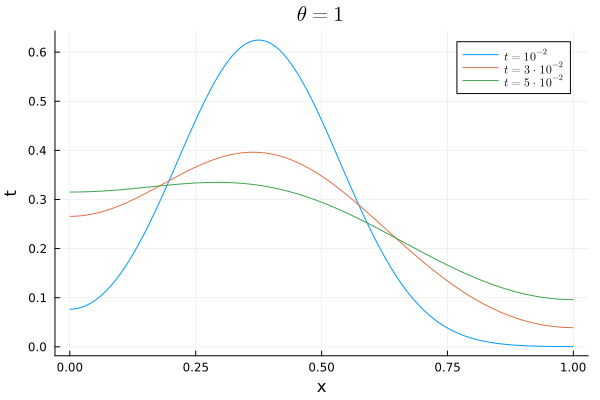

In [18]:
Nx = 1000
dt = 10^-4
T = [10.0^-2, 3.0*10^-2, 5.0*10^-2]

plt = []

for t in T
  x, U = simulate_theta_scheme!(u0, Nx, t, round(Int, t/dt), 1)
  push!(plt, U)
end

p = plot()
plot!(p, x, plt[1], label=L"t=10^{-2}")
plot!(p, x, plt[2], label=L"t=3 \cdot 10^{-2}")
plot!(p, x, plt[3], label=L"t=5 \cdot 10^{-2}")
xlabel!("x")
ylabel!("t")
title!(L"\theta=1")

#LT: super !

Plus le temps final augmente et plus les courbes se lissent (et donc plus la chaleur se diffuse lentement ?)

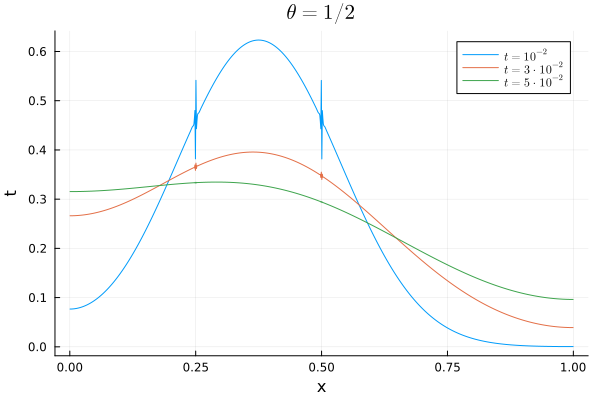

In [19]:
plt = []
Nx = 1000
dt = 10^-4
T = [10.0^-2, 3.0*10^-2, 5.0*10^-2]

for t in T
  x, U = simulate_theta_scheme!(u0, Nx, t, round(Int, t/dt), 0.5)
  push!(plt, U)
end

p = plot()
plot!(p, x, plt[1], label=L"t=10^{-2}")
plot!(p, x, plt[2], label=L"t=3 \cdot 10^{-2}")
plot!(p, x, plt[3], label=L"t=5 \cdot 10^{-2}")
xlabel!("x")
ylabel!("t")
title!(L"\theta=1/2")

Pour $\theta = 1/2$ on à l'impression qu'il y a des problèmes de stabilité autour de $x=0.25$ et $x=0.5$ pour $t = 10^{-2}$, $t = 3\cdot 10^{-2}$.  
Mais le $\theta$-schema à la condition de stabilité :  
$$(1-2 \theta) \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}$$
pour $\theta=1/2$ on obtient la condition de stabilité triviale,  $$0 \leq 1/2$$
Mais la stabilité ne garantie pas que le shema numérique soit immunisé contre les phénomène de Gibbs (comme $u_0$ à des points de discontinuitées) ? (ou alors mon implementation n'est pas bonne ce qui est tout à fait possible).  
Si on diminue le nombre de pas Nx que donc qu'on augmente le grain du maillage on peut éviter ce problème.

**LT:** On peut peut-être le voir un peu comme un phénomène de Gibbs, en effet : les hautes fréquences sont atténuées moins vite qu'elles devraient, donc la solution numérique aussi. Mais, et c'est crucial, on voit ici que les oscillations disparaissent avec le temps. Ça ne serait pas le cas si le schéma était instable ! Bonne analyse en tout cas !

#### 2.3/ Convergence de Crank-Nicholson

**2.3.a)** Pour $N_x = 1000$, calculer une solution précise avec $\theta = 1/2$ au temps $T = 10^{-1}$ en utilisant un pas de temps $\Delta t = 10^{-8}$.

**2.3.b)** Dans une nouvelle cellule, pour $\theta = 1/2$, calculer l'erreur en norme $\ell^2$ pour les pas de temps $\Delta t \in \{10^{-2}, 5\cdot 10^{-3}, 2\cdot 10^{-3}, 10^{-3}, 5\cdot 10^{-4}, ..., 10^{-7}\}$. On pourra utiliser la fonction `norm` de `LinearAlgebra`.

**2.3.c)** Reproduire cela avec $\theta = 1$. Tracer les deux courbes d'erreur en fonction de $\Delta t$ en échelle log-log, et conclure.

In [20]:
"environs 1m40s à l'exécution sur ma machine..." #LT: désolé, je pensais avoir mis T = 0.01...
Nx = 1000
theta = 1/2
T = 0.1
dt = 10^-8
Nt = round(Int64, T/dt)
x, Up = simulate_theta_scheme!(u0, Nx, T, Nt, theta)
# display(Up)

([0.0005, 0.0015, 0.0025, 0.0035, 0.0045000000000000005, 0.0055, 0.006500000000000001, 0.0075, 0.0085, 0.0095  …  0.9905, 0.9915, 0.9925, 0.9935, 0.9945, 0.9955, 0.9965, 0.9975, 0.9985, 0.9995], [0.31330316514208445, 0.31330272619939753, 0.3133018483108264, 0.3133005314699728, 0.31329877566723546, 0.31329658088981577, 0.3132939471217208, 0.3132908743437605, 0.31328736253355594, 0.3132834116655327  …  0.17445387905124185, 0.17444556573150458, 0.17443817575258816, 0.17443170924202475, 0.17442616631141122, 0.17442154705640803, 0.1744178515567359, 0.17441507987617355, 0.17441323206255646, 0.1744123081477762])

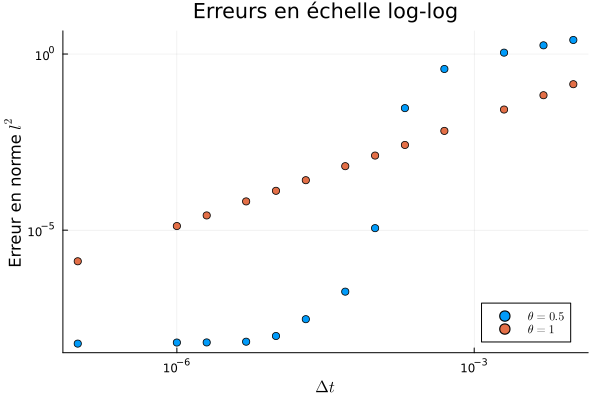

In [21]:
using LinearAlgebra: norm

Dt = [10.0^-2, 5.0*10^-3, 2.0*10^-3,
      10.0^-4, 5.0*10^-4, 2.0*10^-4,
      10.0^-5, 5.0*10^-5, 2.0*10^-5,
      10.0^-6, 5.0*10^-6, 2.0*10^-6,
      10.0^-7]
T = 0.1
err = []
err2 = []

for dt in Dt
  Nt = round(Int64, T/dt)
  x, U = simulate_theta_scheme!(u0, Nx, T, Nt, 0.5)
  x, U2 = simulate_theta_scheme!(u0, Nx, T, Nt, 1)
  push!(err, norm(Up - U, 2))
  push!(err2, norm(Up - U2, 2))
end

p = scatter()
scatter!(p, Dt, err, xscale=:log10, yscale=:log10, label=L"\theta=0.5", legend=:bottomright) 
scatter!(p, Dt, err2, xscale=:log10, yscale=:log10, label=L"\theta=1", legend=:bottomright ) 
xlabel!(L"\Delta t")
ylabel!(L"Erreur en norme $l^2$")
title!("Erreurs en échelle log-log")
#LT: bien de mettre des marqueurs pour mettre en avant le côté discret des mesures

On voit sur les erreurs que la precision de la solution augmente exponentiellement quand $\Delta t \longrightarrow 0$ et $\Delta x \longrightarrow 0$   
(mais le coup, surtout en temps, est aussi plus élevé pour la machine)     
La différence en précision n'est pas flagrante des lors qu'on pas des pas assez petit même si elle quand même un peu meilleur avec Crank-Nicholson, c'est surtout la stabilité de la méthode qui semble être en jeu.  
La methode est d'ordre 1 quand $\theta \neq 1/2$.   
Comme dans le schema de Crank-Nicholson $\theta=1/2$ la methode est stable, de plus est elle d'ordre 2.

**LT:** Bon esprit critique : malgré la théorie qui dit que le schéma de Crank-Nicholson est d'ordre 2, on n'observe pas une erreur bien meilleure sur le schéma. Est-ce qu'on observe cet ordre 2 sur la courbe de convergence ?